In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm, tnrange
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans
import pandas as pd


In [3]:
basepath = Path('E:\Documents\EPF\PFE\Work\Codes\check\Videos').resolve()
# basepath = Path('2021-03-12_09-44-08/').resolve()
videos = list(sorted(basepath.glob('eye*.mp4')))
print(videos)
crop_instruct = Path(basepath / videos[0].name[6:]).with_suffix('.led_crop')
print(crop_instruct, "-- Exists:", crop_instruct.exists())

[WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye01_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye02_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye03_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye04_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye05_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye06_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye07_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye08_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye09_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye10_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye11_2020-11-09_12-34-18.mp4')

In [3]:
print(videos)

[WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye01_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye02_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye03_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye04_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye05_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye06_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye07_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye08_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye09_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye10_2020-11-09_12-34-18.mp4'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye11_2020-11-09_12-34-18.mp4')

# Extract example frames

Use these to find the center of the led visible in the image, and note `filepath, x, y` in the `.led_crop` file

Run this if there are no example images with the videos yet

In [4]:
overwrite = False
if crop_instruct.exists() and overwrite:
    print(f'Deleting existing crop file {crop_instruct}')
    crop_instruct.unlink()
    
for vid in tqdm(videos):
    cap = cv2.VideoCapture(str(vid))
    rv, frame = cap.read()
    outfile = vid.with_suffix('.png')
    if not outfile.exists() or overwrite:
        cv2.imwrite(str(vid.with_suffix('.png')), frame)

    if overwrite:
        with open(crop_instruct, 'a') as led_crop_file:
            led_crop_file.write(f'{str(vid)}, , \n')
    print(str(vid.with_suffix('.png')))

  0%|          | 0/12 [00:00<?, ?it/s]

E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye01_2020-11-09_12-34-18.png
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye02_2020-11-09_12-34-18.png
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye03_2020-11-09_12-34-18.png
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye04_2020-11-09_12-34-18.png
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye05_2020-11-09_12-34-18.png
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye06_2020-11-09_12-34-18.png
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye07_2020-11-09_12-34-18.png
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye08_2020-11-09_12-34-18.png
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye09_2020-11-09_12-34-18.png
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye10_2020-11-09_12-34-18.png
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye11_2020-11-09_12-34-18.png
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye12_2020-11-09_12-34-18.png


# Create cropped RGB image stacks around the LED centers

Can optionally create RGB and YUV stacks, though RGB turned out to be sufficient for extraction of most views

In [5]:
with open(crop_instruct) as f:
    crop_txt = f.readlines()
overwrite = False
crop = 16
FFMPEG_CMD = 'ffmpeg -hide_banner -y -i "{infile}" -vf crop={crop}:{crop}:{x}:{y} -c:v rawvideo -pix_fmt {fmt} "{outfile}"'
formats = {'rgb': 'rgb24'}  # , 'yuv': 'yuv444p'
for line in tqdm(crop_txt):
    try:
        v, x, y = line.split(',')
        x, y = int(x), int(y)
    except ValueError:
        print("Faulty line:", line, 'Maybe led coordinates are missing?')
        break

    infile = basepath / Path(v).name

    #print(infile)

    
    for ext, fmt in formats.items():
        # print(ext)
        outfile = basepath / Path(v).with_suffix('.'+ext).name
        print(outfile)
        if overwrite or not outfile.exists():
            cmd = FFMPEG_CMD.format(infile=str(infile), crop=crop, x=x-crop//2, y=y-crop//2, fmt=fmt, outfile=str(outfile));
            os.system(cmd);

  0%|          | 0/12 [00:00<?, ?it/s]

E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye01_2020-11-09_12-34-18.rgb
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye02_2020-11-09_12-34-18.rgb
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye03_2020-11-09_12-34-18.rgb
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye04_2020-11-09_12-34-18.rgb
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye05_2020-11-09_12-34-18.rgb
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye06_2020-11-09_12-34-18.rgb
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye07_2020-11-09_12-34-18.rgb
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye08_2020-11-09_12-34-18.rgb
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye09_2020-11-09_12-34-18.rgb
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye10_2020-11-09_12-34-18.rgb
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye11_2020-11-09_12-34-18.rgb
E:\Documents\EPF\PFE\Work\Codes\check\Videos\eye12_2020-11-09_12-34-18.rgb


# Generate image stack arrays in RGB, HSV and YUV

In [6]:
rgb_frames = np.fromfile(videos[0].with_suffix('.rgb'), dtype=np.uint8).reshape(-1, 16, 16, 3)
#yuv_frames = np.fromfile(videos[0].with_suffix('.yuv'), dtype=np.uint8).reshape(-1, 16, 16, 3)
hsv_frames = np.zeros_like(rgb_frames)
for n in range(rgb_frames.shape[0]):
    hsv_frames[n,:,:,:] = cv2.cvtColor(rgb_frames[n,:,:,:], cv2.COLOR_RGB2HSV).astype(float)

# Classic

Get a mask of "active pixels" from product of saturation and value.

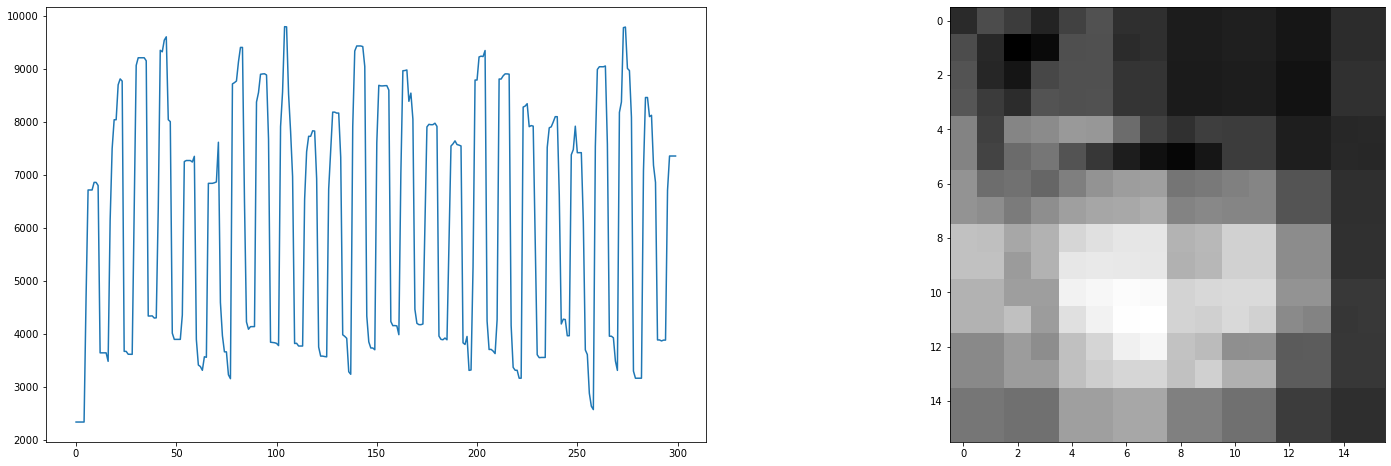

In [7]:
hv = hsv_frames[:,:,:,1].astype(float) * hsv_frames[:,:,:,2].astype(float)
hv_mask = hv.mean(axis=0)
hv_mask = (hv_mask -hv_mask.min()) / (hv_mask.max() - hv_mask.min())
hvs = hv.mean(axis=1).mean(axis=1)
fig, ax = plt.subplots(1, 2, figsize=(26, 8))
ax[0].plot(hvs[:300])
ax[1].imshow(hv_mask, cmap='gray')

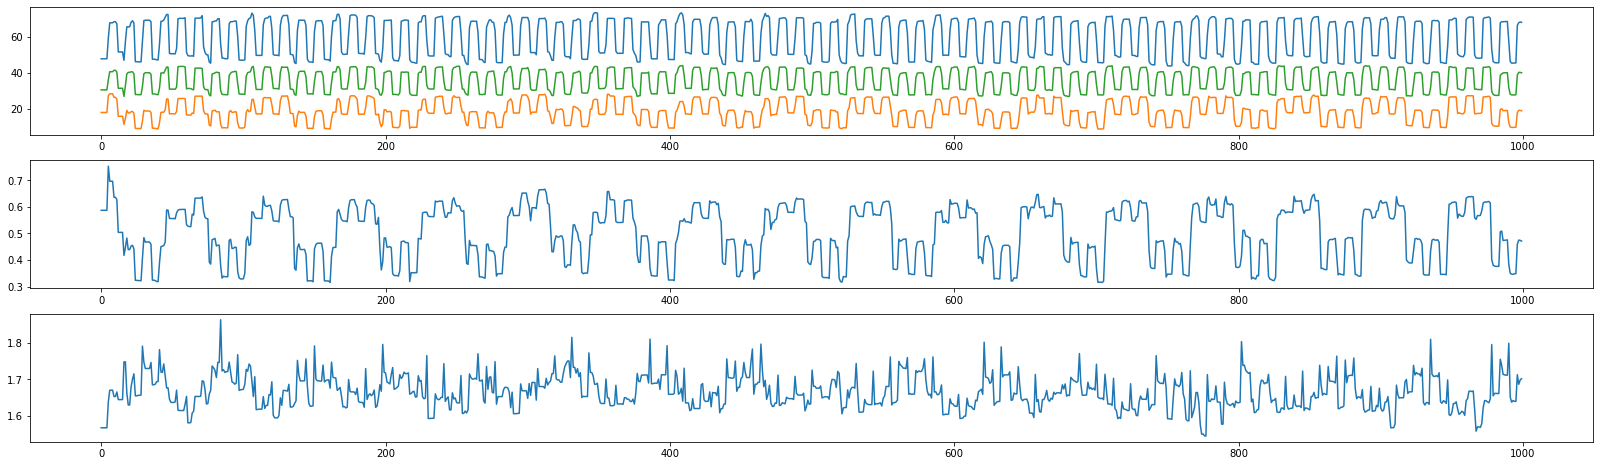

In [8]:
N = 1000
r = (rgb_frames[:N,:,:,0].astype(float)*hv_mask).mean(axis=1).mean(axis=1)
g = (rgb_frames[:N,:,:,1].astype(float)*hv_mask).mean(axis=1).mean(axis=1)+15
b = (rgb_frames[:N,:,:,2].astype(float)*hv_mask).mean(axis=1).mean(axis=1)+30
fig, ax = plt.subplots(3, figsize=(28, 8))
ax[0].plot(b)
ax[0].plot(r)
ax[0].plot(g)
ax[1].plot(r/g)
ax[2].plot(b/g)

# ICA
## RGB Frames

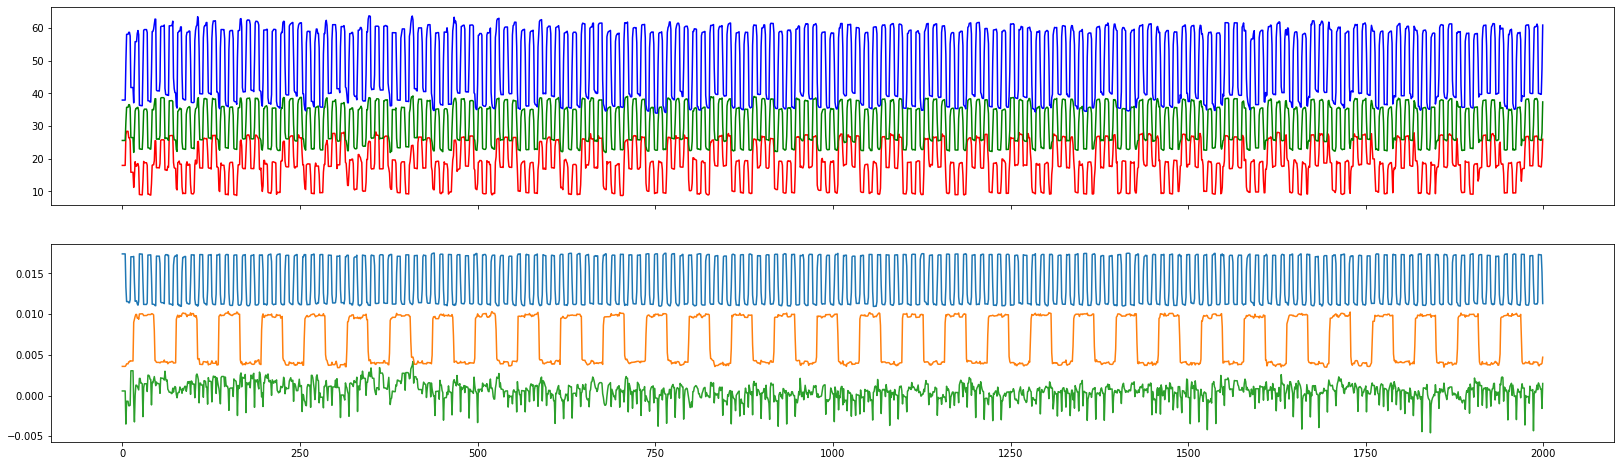

In [10]:
nc = 3
ica = FastICA(n_components=nc, random_state=0)
X = rgb_frames.reshape(rgb_frames.shape[0], -1).astype(float)
demixed = ica.fit_transform(X)
mix_matrix = ica.mixing_

N = 2000
fig, ax = plt.subplots(2, figsize=(28, 8), sharex=True)
col = ['r', 'g', 'b']
for n in range(3):
    ax[0].plot((rgb_frames[:N,:,:,n].astype(float)*hv_mask).mean(axis=1).mean(axis=1)+10*n, c=col[n])
    ax[1].plot(demixed[:N,n]+0.007*n, c=f'C{2-n}')

# fig, ax = plt.subplots(nc, figsize=(28, 8), sharey=True, sharex=True)
# for n in range(nc):
#     ax[n].plot(demixed[:2000,n], c=f'C{2-n}')

## YUV frames

In [8]:
nc = 3
ica = FastICA(n_components=nc, random_state=0)
X = yuv_frames.reshape(yuv_frames.shape[0], -1).astype(float)
demixed = ica.fit_transform(X)
mix_matrix = ica.mixing_

N = 2000
fig, ax = plt.subplots(2, figsize=(28, 8), sharex=True)
col = ['r', 'g', 'b']
for n in range(3):
    ax[0].plot((yuv_frames[:N,:,:,n].astype(float)).mean(axis=1).mean(axis=1)+15*n, c=col[n])
    ax[1].plot(demixed[:N,n]+0.01*n, c=f'C{2-n}')

NameError: name 'yuv_frames' is not defined

## HSV Frames

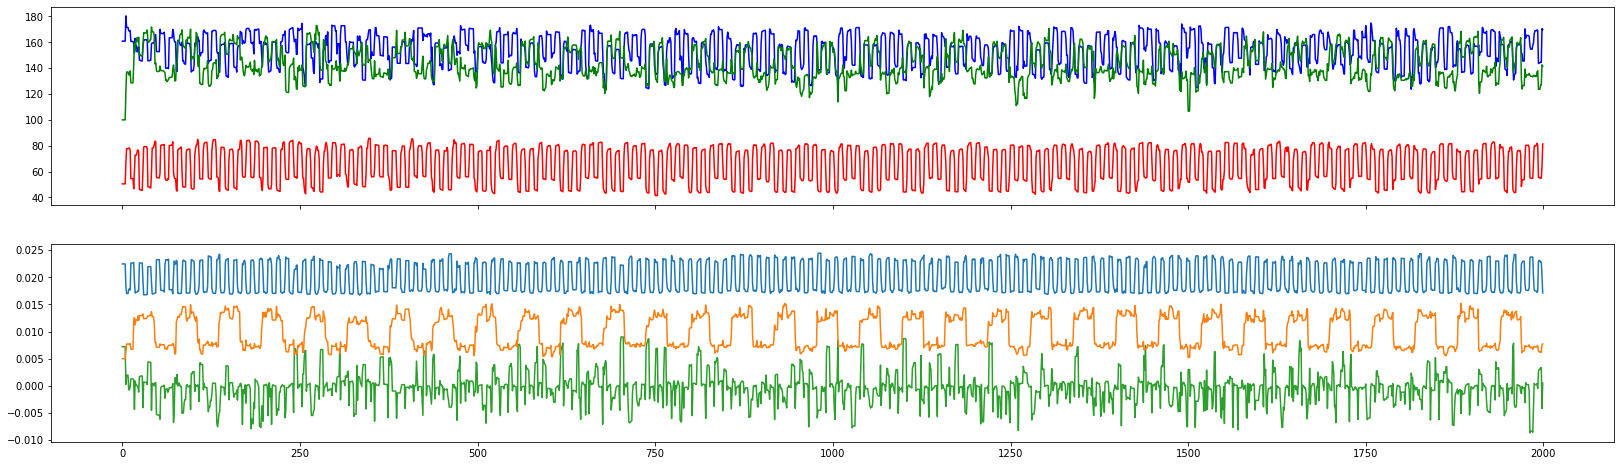

In [9]:
nc = 3
ica = FastICA(n_components=nc, random_state=0)
X = hsv_frames.reshape(hsv_frames.shape[0], -1).astype(float)
demixed = ica.fit_transform(X)
mix_matrix = ica.mixing_

N = 2000
fig, ax = plt.subplots(2, figsize=(28, 8), sharex=True)
col = ['r', 'g', 'b']
for n in range(3):
    ax[0].plot((hsv_frames[:N,:,:,n].astype(float)).mean(axis=1).mean(axis=1)+25*(2-n), c=col[2-n])
    ax[1].plot(demixed[:N,n]+0.01*n, c=f'C{2-n}')

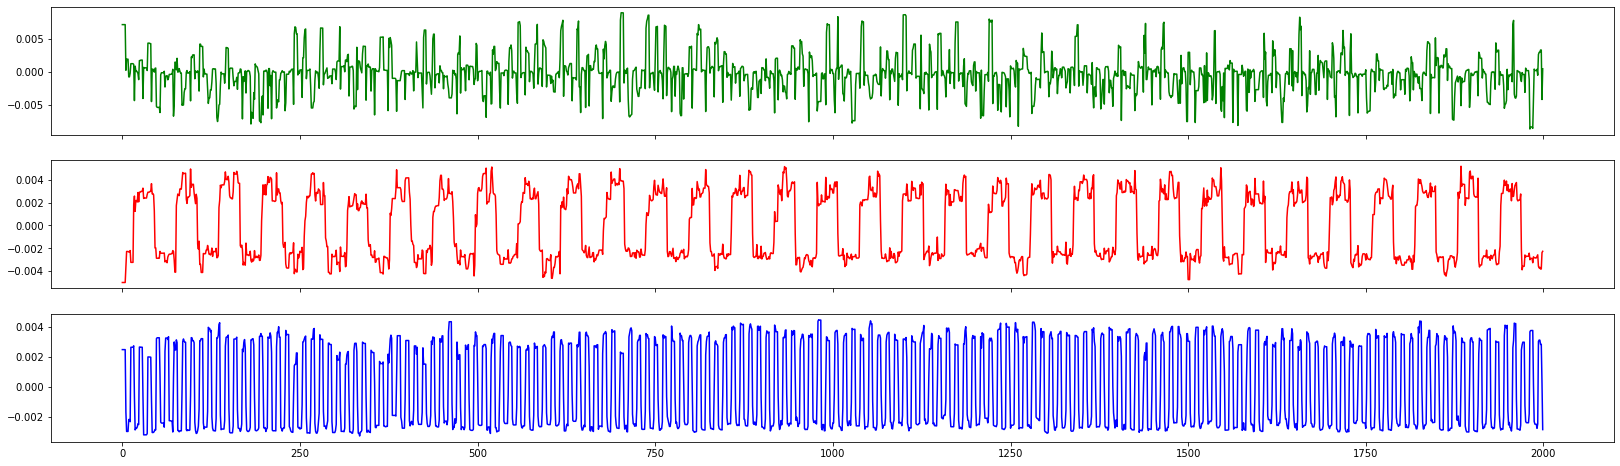

In [25]:
fig, ax = plt.subplots(3, figsize=(28, 8), sharex=True)


ax[0].plot(demixed[:N,0],'g') #noise
ax[1].plot(demixed[:N,1],'r') #red
ax[2].plot(demixed[:N,2],'b') #blue

# Signal Identity
Kmeans clustering of the the ICA extracted sources for state separation and compare with the expected properties of our signals.

Note the polarity of the ICA signal/kmeans cluster identity signal may be reversed, so we need to check the mixing weights and locations of the cluster centers to restore polarity correctly.

D=0.10%, f=0.01 Hz
flip! [[ 0.00293723]
 [-0.00286114]]
D=49.34%, f=0.50 Hz
flip! [[ 0.00318723]
 [-0.002573  ]]
D=44.67%, f=2.48 Hz
Expected D=50.0%, f_red=0.5 Hz, f_blue=2.5 Hz


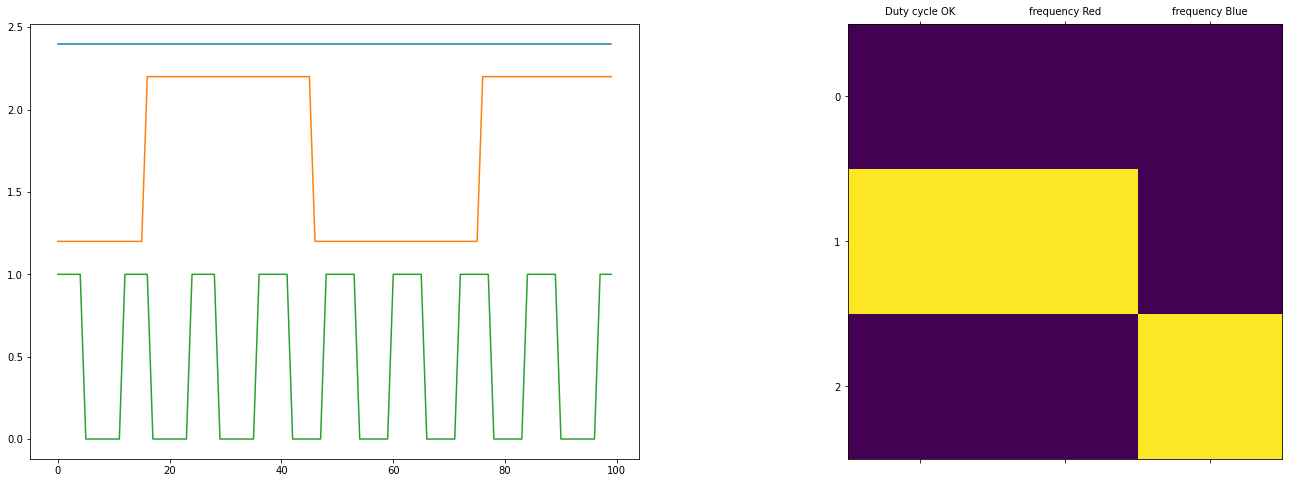

In [11]:
eD = 0.5
dD = np.zeros(demixed.shape[1])  # distance to expected Duty cycle of 0.5
ef_red = 0.5
df_red = np.zeros(demixed.shape[1])  # distance to expected frequency of 0.5 Hz
ef_blue = 2.5
df_blue = np.zeros(demixed.shape[1])  # distance to expected frequency of 2.5 Hz

fig, ax = plt.subplots(1, 2, figsize=(24, 8))

kmeans = []

for n in range(demixed.shape[1]):
    km = KMeans(n_clusters=2, random_state=0).fit(demixed[:, n].reshape(-1, 1))
    y_km = km.predict(demixed[:, n].reshape(-1, 1))
    kmeans.append(y_km)
    centers = km.cluster_centers_
    
    # check center location, flip polarity if necessary to match pulse polarity
    if centers[0] > centers[1]:
        print('flip!', centers)
        y_km = np.abs(y_km-1)

    ax[0].plot(y_km[:100]+1.2*(2-n))
    duty_cycle = y_km.sum()/len(y_km)
    freq = (np.diff(y_km)>0).sum()/len(y_km) * 30
    dD[n] = abs(eD-duty_cycle)
    df_red[n] = abs(ef_red - freq)
    df_blue[n] = abs(ef_blue - freq)
    print(f'D={duty_cycle*100:.2f}%, f={freq:.2f} Hz')
ax[1].matshow(np.c_[dD<eD/10, df_red<ef_red/10, df_blue<ef_blue/10])
ax[1].set_xticks(range(3))
ax[1].set_xticklabels(['Duty cycle OK', 'frequency Red', 'frequency Blue'])
print(f'Expected D={eD*100}%, f_red={ef_red} Hz, f_blue={ef_blue} Hz')

# Compute for all eyes

  0%|          | 0/12 [00:00<?, ?it/s]

--- eye01_2020-11-09_12-34-18.mp4 ---
3
ICA Mix: [  5.12958462 923.7626332  377.5303312 ]
Centers: -6.12, 13.54
Polarity FLIP: False (ICA False, kmeans False)
Signal: None (D=31.13%, f=0.07 Hz)
Centers: -10.85, 8.84
Polarity FLIP: False (ICA False, kmeans False)
Signal: blue (D=55.10%, f=2.48 Hz)
Centers: -10.08, 9.79
Polarity FLIP: False (ICA False, kmeans False)
Signal: red (D=50.73%, f=0.50 Hz)
--- eye02_2020-11-09_12-34-18.mp4 ---
3
ICA Mix: [-22.21938048 435.03625001 871.59721116]
Centers: -24.05, 2.48
Polarity FLIP: True (ICA True, kmeans False)
Signal: None (D=90.69%, f=2.49 Hz)
Centers: -10.08, 9.83
Polarity FLIP: False (ICA False, kmeans False)
Signal: red (D=50.65%, f=0.50 Hz)
Centers: -10.59, 9.13
Polarity FLIP: False (ICA False, kmeans False)
Signal: blue (D=53.72%, f=2.48 Hz)
--- eye03_2020-11-09_12-34-18.mp4 ---
3
ICA Mix: [ -88.5315769  -884.82775801 -422.92637045]
Centers: -8.13, 8.69
Polarity FLIP: True (ICA True, kmeans False)
Signal: None (D=48.34%, f=2.76 Hz)
Center

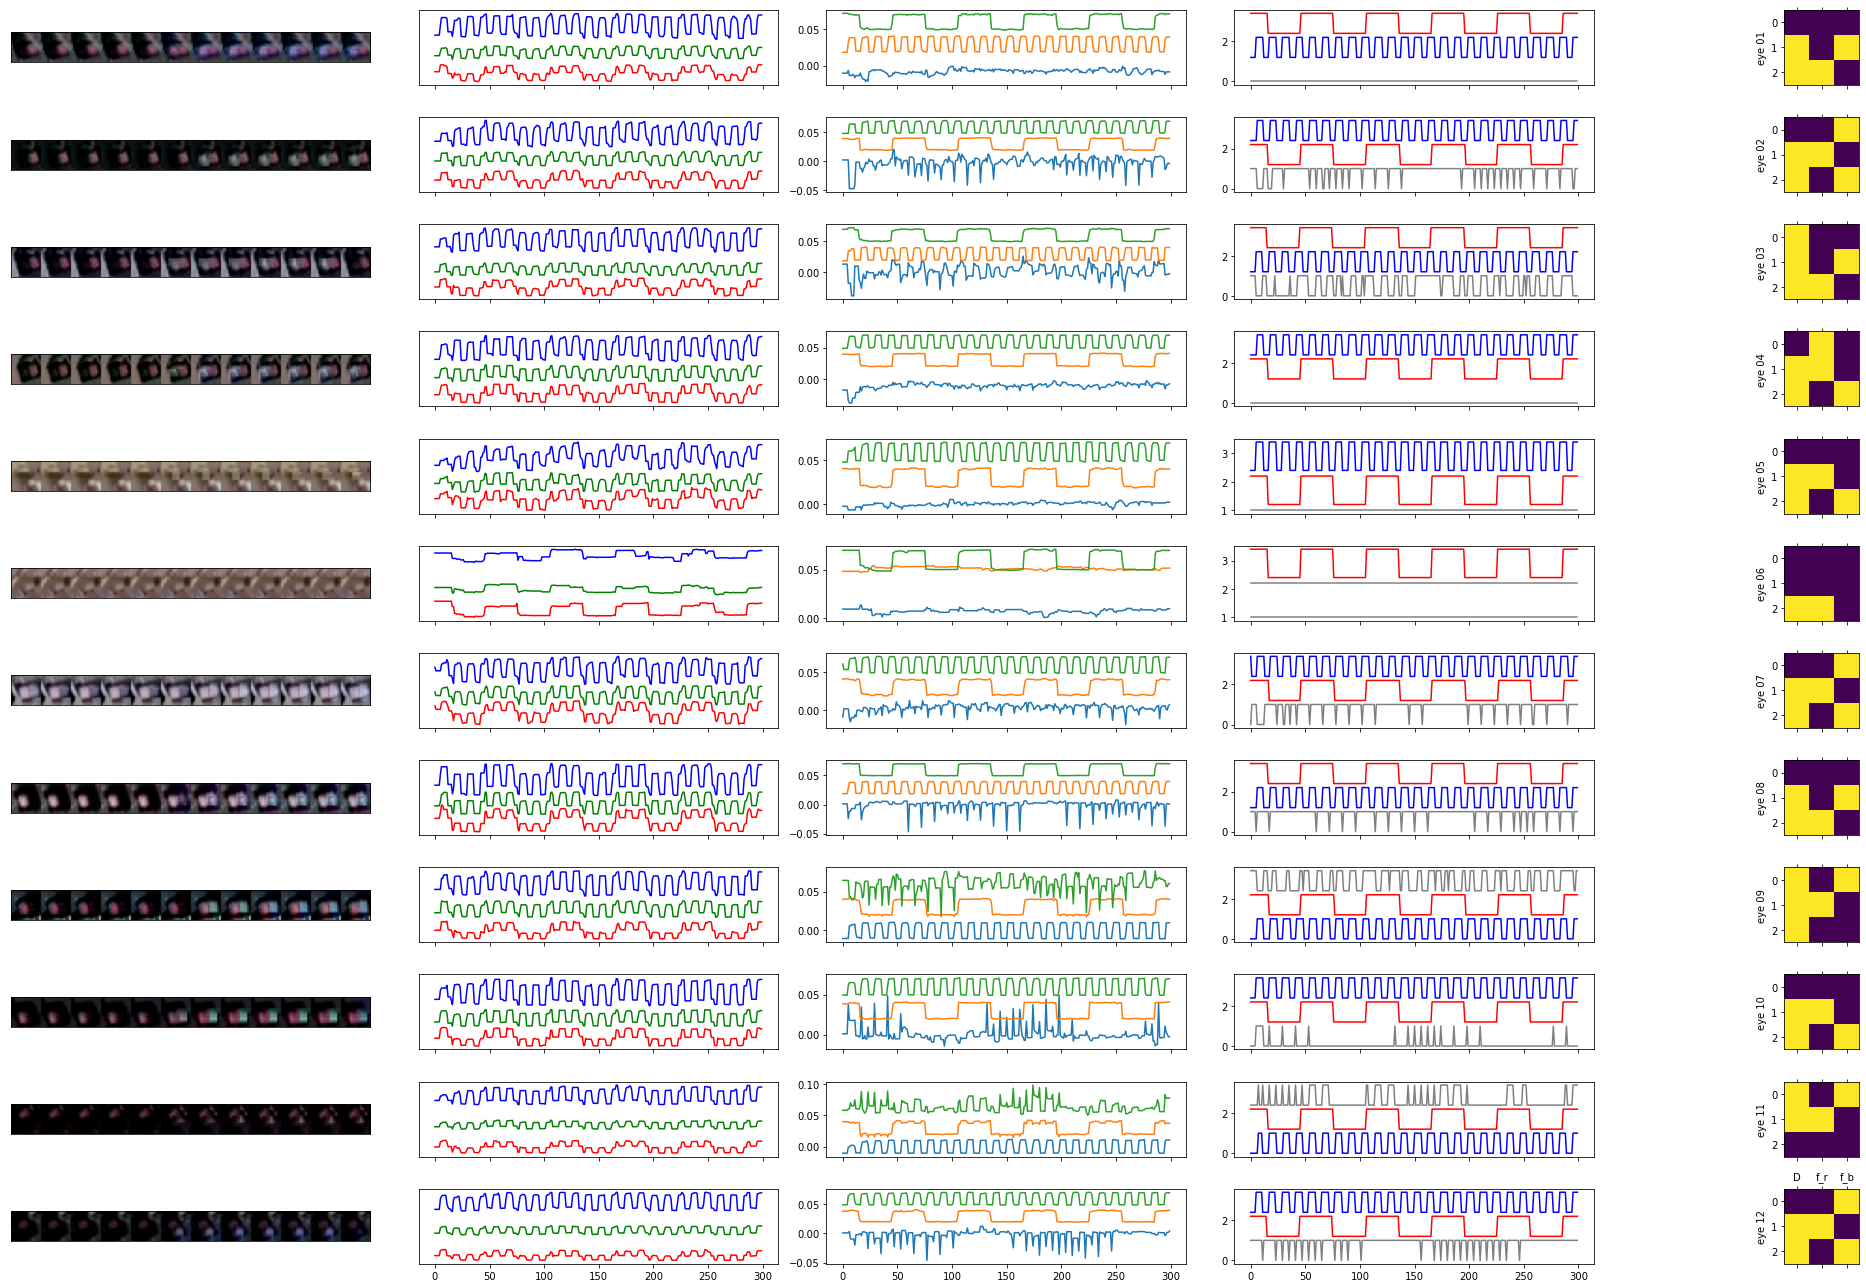

In [11]:
n_im = 12
    
# properties of our signals
fps = 30
eD = 0.5       # expected Duty cycle of 0.5
ef_red = 0.5   # expected frequency of 0.5 Hz
ef_blue = 2.5  # expected frequency of 2.5 Hz

colors = {0: 'red', 1: 'blue', None: 'gray'}
N = 300
N_ICA = 10000  # numbers of samples to use for ICA, -1 for all

led_signals = np.zeros([rgb_frames.shape[0], 2], dtype=np.double)
fig, ax = plt.subplots(12, 5, figsize=(28, 18), sharex="col") ##  sharey=True
for eye in tnrange(12):
    print(f'--- {videos[eye].name} ---')
    
    rgb_frames = np.fromfile(videos[eye].with_suffix('.rgb'), dtype=np.uint8).reshape(-1, 16, 16, 3)
    for n, c in enumerate(['r', 'g', 'b']):
        ax[eye, 1].plot(rgb_frames[:N,:,:,n].astype(float).mean(axis=1).mean(axis=1)+30*n, c=c)
        ax[eye, 1].axes.yaxis.set_visible(False)
    
    # ICA to extract blinking signals from noise/variation
    num_components = 3
    ica = FastICA(n_components=num_components, random_state=0)
    demixed = ica.fit_transform(rgb_frames.reshape(rgb_frames.shape[0], -1).astype(float)[:N_ICA, :])
    mix_weights = ica.mixing_.mean(axis=0)
    
    dD = np.zeros(demixed.shape[1])
    df_red = np.zeros(demixed.shape[1])
    df_blue = np.zeros(demixed.shape[1])
    print(len(df_red))
    print(f'ICA Mix: {mix_weights}')
    
    for n in range(demixed.shape[1]):
        # Check the mixing weights if the demixed signal polarity is reversed
        # (negative weights for ROI. Assuming rest of pixel array has weight zero, mean weight tells us sign.)
        flip_ica = mix_weights[n] < 0
        if flip_ica:
            demixed[:, n] = -demixed[:, n]

        km = KMeans(n_clusters=2, random_state=0).fit(demixed[:, n].reshape(-1, 1))
        y_km = km.predict(demixed[:, n].reshape(-1, 1))

        # check polarity, if necessary flip to match pulse polarity
        print(f'Centers: {float(km.cluster_centers_[0]*1000):.2f}, {float(km.cluster_centers_[1]*1000):.2f}')
        centers = km.cluster_centers_.ravel()

        flip_kmeans = centers[0] > centers[1]
        flip = flip_ica ^ flip_kmeans
        print(f'Polarity FLIP: {flip} (ICA {flip_ica}, kmeans {flip_kmeans})')
        if flip_kmeans:
            print('Flipping!')
            y_km = np.abs(y_km-1)

        duty_cycle = y_km.sum()/len(y_km)
        freq = (np.diff(y_km)>0).sum()/len(y_km) * fps
        dD[n] = abs(eD-duty_cycle)
        df_red[n] = abs(ef_red - freq)
        df_blue[n] = abs(ef_blue - freq)
        
        # Attempt to identify the ICA signal as a color LED
        good_DC = dD[n] < 0.2 * eD
        good_freq = np.array([df_red[n] < ef_red * 0.1, df_blue[n] < ef_blue * 0.1])
        is_signal = good_DC and good_freq.sum()
        signal_color = good_freq.argmax() if is_signal else None
        
        sig_col = colors[signal_color]
        sig_name = 'None' if signal_color is None else colors[signal_color]
        print(f'Signal: {sig_name} (D={duty_cycle*100:.2f}%, f={freq:.2f} Hz)')
        ax[eye, 3].plot(y_km[:N]+1.2*n, c=sig_col)
        
        
        
        
        if signal_color is not None:
            lim = min(len(y_km), len(led_signals))
            led_signals[:lim, signal_color] += y_km[:lim]

        
    candidates = np.c_[dD < 0.2 * eD, df_red < ef_red * 0.1, df_blue < ef_blue * 0.1]
#     is_signal = np.logical_and(candidates[:, 0], np.sum(candidates[:, 1:]))
#     signal_color = [np.argmax(candidates[ns, 1:]) if is_signal[ns] else None for ns in range(candidates.shape[0])]
    ax[eye, 4].matshow(candidates)
    ax[eye, 4].set_xticks([0, 1, 2])
    ax[eye, 4].set_xticklabels(['D', 'f_r', 'f_b'])
    ax[eye, 4].set_ylabel(f'eye {eye+1:02d}')

    # Attempt to identify the ICA signal as a color LED
#     is_signal = np.logical_and(candidates[:, 0], np.sum(candidates[:, 1:]))
#     signal_color = [np.argmax(candidates[ns, 1:]) if is_signal[ns] else None for ns in range(candidates.shape[0])]
    
    rgb_arr = np.zeros((rgb_frames.shape[1], rgb_frames.shape[2]*n_im, 3), dtype=np.uint8)
    for n in range(n_im):
        rgb_arr[:,16*n:16*(n+1), :] = rgb_frames[n,:,:,:]

    ax[eye, 0].imshow(rgb_arr)
    ax[eye, 0].axes.xaxis.set_visible(False)
    ax[eye, 0].axes.yaxis.set_visible(False)
    ax[eye, 0].set_ylabel(f'eye {eye+1:02d}')

    for nc in range(num_components):
        ax[eye, 2].plot(demixed[:N,nc]+0.03*nc, c=f'C{nc:02d}')
    
#     break
plt.tight_layout()
plt.savefig('fig1.png')

In [8]:
basepath = Path('E:\Documents\EPF\PFE\Work\Codes\check\Videos').resolve()
# basepath = Path('2021-03-12_09-44-08/').resolve()
time_stamps = list(sorted(basepath.glob('eye*.csv')))
print(time_stamps)
# df_timestamps = np.zeros()
# for i in range(len(time_stamps)):
   

[WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye01_2020-11-09_12-34-18.csv'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye02_2020-11-09_12-34-18.csv'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye03_2020-11-09_12-34-18.csv'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye04_2020-11-09_12-34-18.csv'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye05_2020-11-09_12-34-18.csv'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye06_2020-11-09_12-34-18.csv'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye07_2020-11-09_12-34-18.csv'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye08_2020-11-09_12-34-18.csv'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye09_2020-11-09_12-34-18.csv'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye10_2020-11-09_12-34-18.csv'), WindowsPath('E:/Documents/EPF/PFE/Work/Codes/check/Videos/eye11_2020-11-09_12-34-18.csv')

  0%|          | 0/12 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11


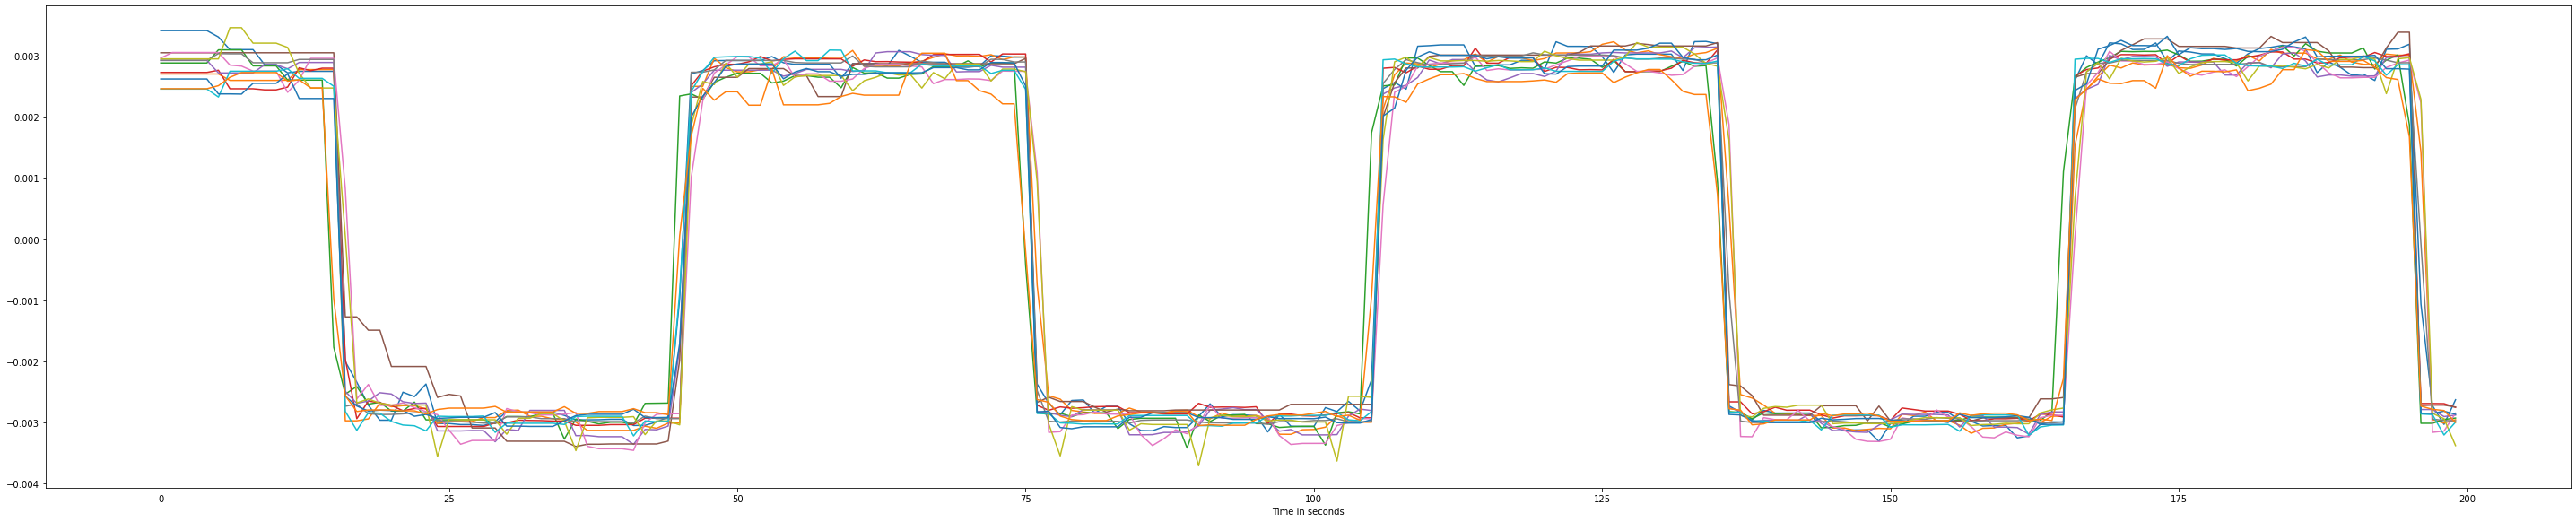

In [18]:
n_im = 12
import pandas
import functools as ft
var_holder = {}
# properties of our signals
fps = 30
eD = 0.5       # expected Duty cycle of 0.5
ef_red = 0.5   # expected frequency of 0.5 Hz
ef_blue = 2.5  # expected frequency of 2.5 Hz



colors = {0: 'red', 1: 'blue', None: 'gray'}
N = 200
N_ICA = -1  # numbers of samples to use for ICA, -1 for all

led_signals = np.zeros([rgb_frames.shape[0], 2], dtype=np.double)
fig, ax = plt.subplots(1, figsize=(40, 8), sharex="col", sharey=True )
first = 0
for eye in tnrange(12):

    rgb_frames = np.fromfile(videos[eye].with_suffix('.rgb'), dtype=np.uint8).reshape(-1, 16, 16, 3)

    # ICA to extract blinking signals from noise/variation
    num_components = 3
    ica = FastICA(n_components=num_components, random_state=0)
    demixed = ica.fit_transform(rgb_frames.reshape(rgb_frames.shape[0], -1).astype(float)[:N_ICA, :])
    mix_weights = ica.mixing_.mean(axis=0)
    
    dD = np.zeros(demixed.shape[1])
    df_red = np.zeros(demixed.shape[1])
    df_blue = np.zeros(demixed.shape[1])
    df_red_vs_time = pandas.DataFrame({'key' : [], 'r' : []})

    data = np.genfromtxt(time_stamps[eye], delimiter=',', names=True)
    time_meta = data['Timestamps_M']
    for n in range(demixed.shape[1]):

        # Check the mixing weights if the demixed signal polarity is reversed
        # (negative weights for ROI. Assuming rest of pixel array has weight zero, mean weight tells us sign.)
        flip_ica = mix_weights[n] < 0
        if flip_ica:
            demixed[:, n] = -demixed[:, n]

        km = KMeans(n_clusters=2, random_state=0).fit(demixed[:, n].reshape(-1, 1))
        y_km = km.predict(demixed[:, n].reshape(-1, 1))

        # check polarity, if necessary flip to match pulse polarity
        centers = km.cluster_centers_.ravel()

        flip_kmeans = centers[0] > centers[1]
        flip = flip_ica ^ flip_kmeans

        if flip_kmeans:
            y_km = np.abs(y_km-1)

        duty_cycle = y_km.sum()/len(y_km)
        freq = (np.diff(y_km)>0).sum()/len(y_km) * fps
        dD[n] = abs(eD-duty_cycle)
        df_red[n] = abs(ef_red - freq)
        df_blue[n] = abs(ef_blue - freq)
        
        # Attempt to identify the ICA signal as a color LED
        good_DC = dD[n] < 0.2 * eD
        good_freq = np.array([df_red[n] < ef_red * 0.1, df_blue[n] < ef_blue * 0.1])
        is_signal = good_DC and good_freq.sum()
        signal_color = good_freq.argmax() if is_signal else None
        
        sig_col = colors[signal_color]
        sig_name = 'None' if signal_color is None else colors[signal_color]

        if sig_col=='red':
            a = y_km[:N]
            df_temp = pandas.DataFrame({'key' : [], "Red_LED_Intensity_%s" %(eye) : []})
            df_temp['key'] = time_meta[0:len(demixed[:N, n])]
            df_temp["Red_LED_Intensity_%s" %(eye)] = demixed[:N, n]
            ax.plot(demixed[:N, n])
            print(eye)
            if eye==0:
                df0 = df_temp
            elif eye==1:
                df1 = df_temp
            elif eye==2:
                df2 = df_temp
            elif eye==3:
                df3 = df_temp
            elif eye==4:
                df4 = df_temp
            elif eye==5:
                df5 = df_temp
            elif eye==6:
                df6 = df_temp
            elif eye==7:
                df7 = df_temp
            elif eye==8:
                df8 = df_temp
            elif eye==9:
                df9 = df_temp
            elif eye==10:
                df10 = df_temp
            elif eye==11:
                df11 = df_temp
                

plt.tight_layout()
ax.set_xlabel('Time in seconds')
plt.savefig('ICA_for_each_eye_red_LED_intensity.png');



  0%|          | 0/12 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11


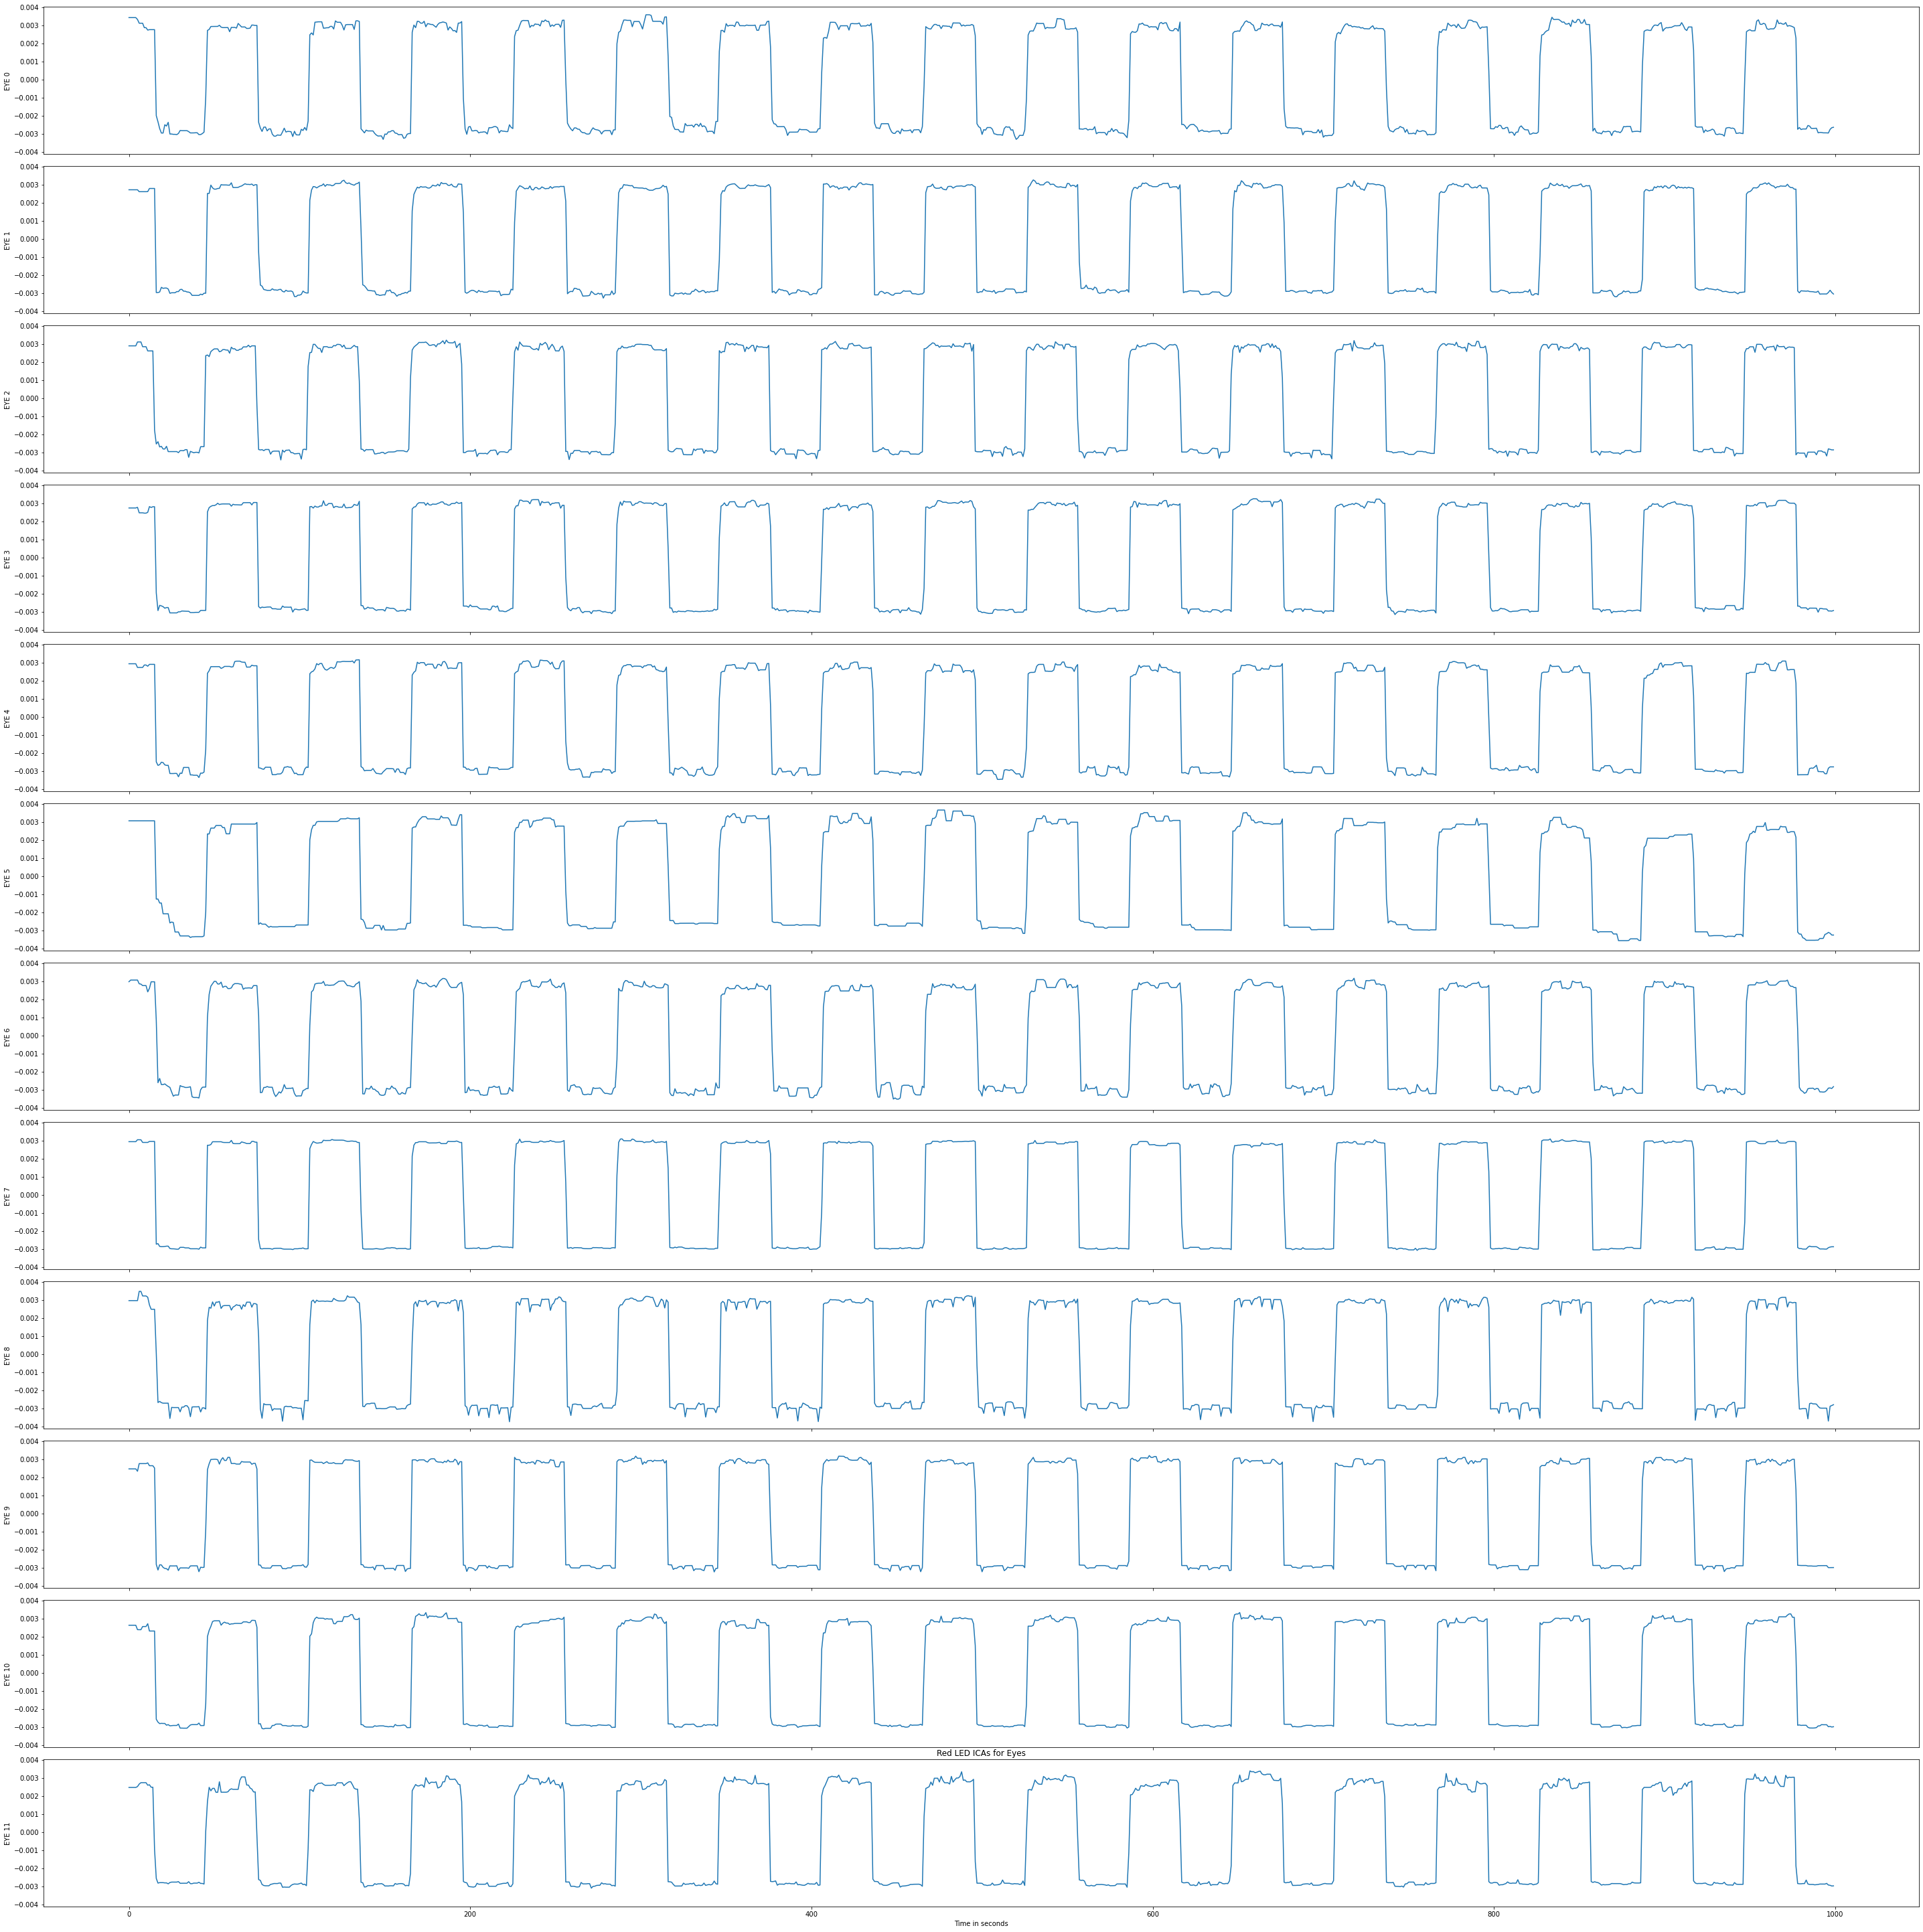

In [9]:
n_im = 12
import pandas
import functools as ft
var_holder = {}
# properties of our signals
fps = 30
eD = 0.5       # expected Duty cycle of 0.5
ef_red = 0.5   # expected frequency of 0.5 Hz
ef_blue = 2.5  # expected frequency of 2.5 Hz



colors = {0: 'red', 1: 'blue', None: 'gray'}
N = 1000
N_ICA = -1  # numbers of samples to use for ICA, -1 for all

led_signals = np.zeros([rgb_frames.shape[0], 2], dtype=np.double)
fig, ax = plt.subplots(12,1, figsize=(40, 40), sharex=True, sharey=True )
first = 0
for eye in tnrange(12):
    # print(f'--- {videos[eye].name} ---')
    #print(eye)
    rgb_frames = np.fromfile(videos[eye].with_suffix('.rgb'), dtype=np.uint8).reshape(-1, 16, 16, 3)
    
    # ICA to extract blinking signals from noise/variation
    num_components = 3
    ica = FastICA(n_components=num_components, random_state=0)
    demixed = ica.fit_transform(rgb_frames.reshape(rgb_frames.shape[0], -1).astype(float)[:N_ICA, :])
    mix_weights = ica.mixing_.mean(axis=0)
    
    dD = np.zeros(demixed.shape[1])
    df_red = np.zeros(demixed.shape[1])
    df_blue = np.zeros(demixed.shape[1])
    df_red_vs_time = pandas.DataFrame({'key' : [], 'r' : []})

    data = np.genfromtxt(time_stamps[eye], delimiter=',', names=True)
    time_meta = data['Timestamps_M']
    for n in range(demixed.shape[1]):

        # Check the mixing weights if the demixed signal polarity is reversed
        # (negative weights for ROI. Assuming rest of pixel array has weight zero, mean weight tells us sign.)
        flip_ica = mix_weights[n] < 0
        if flip_ica:
            demixed[:, n] = -demixed[:, n]

        km = KMeans(n_clusters=2, random_state=0).fit(demixed[:, n].reshape(-1, 1))
        y_km = km.predict(demixed[:, n].reshape(-1, 1))

        # check polarity, if necessary flip to match pulse polarity
        centers = km.cluster_centers_.ravel()

        flip_kmeans = centers[0] > centers[1]
        flip = flip_ica ^ flip_kmeans

        if flip_kmeans:
            y_km = np.abs(y_km-1)

        duty_cycle = y_km.sum()/len(y_km)
        freq = (np.diff(y_km)>0).sum()/len(y_km) * fps
        dD[n] = abs(eD-duty_cycle)
        df_red[n] = abs(ef_red - freq)
        df_blue[n] = abs(ef_blue - freq)
        
        # Attempt to identify the ICA signal as a color LED
        good_DC = dD[n] < 0.2 * eD
        good_freq = np.array([df_red[n] < ef_red * 0.1, df_blue[n] < ef_blue * 0.1])
        is_signal = good_DC and good_freq.sum()
        signal_color = good_freq.argmax() if is_signal else None
        
        sig_col = colors[signal_color]
        sig_name = 'None' if signal_color is None else colors[signal_color]
        
        if sig_col=='red':
            a = y_km[:N]
            df_temp = pandas.DataFrame({'key' : [], "Red_LED_Intensity_%s" %(eye) : []})
            df_temp['key'] = time_meta[0:(len(demixed[:N, n]-1))]
            df_temp["Red_LED_Intensity_%s" %(eye)] = demixed[:N, n]
            ax[eye].plot(demixed[:N, n])
            ax[eye].set_ylabel('EYE ' + str(eye))

            print(eye)
            if eye==0:
                df0 = df_temp
            elif eye==1:
                df1 = df_temp
            elif eye==2:
                df2 = df_temp
            elif eye==3:
                df3 = df_temp
            elif eye==4:
                df4 = df_temp
            elif eye==5:
                df5 = df_temp
            elif eye==6:
                df6 = df_temp
            elif eye==7:
                df7 = df_temp
            elif eye==8:
                df8 = df_temp
            elif eye==9:
                df9 = df_temp
            elif eye==10:
                df10 = df_temp
            elif eye==11:
                df11 = df_temp

plt.tight_layout()
ax[11].set_xlabel('Time in seconds')
plt.title('Red LED ICAs for Eyes')
plt.savefig('Red_LED_ICAs_for_Eyes.png');



  0%|          | 0/12 [00:00<?, ?it/s]

0
1
2
3
4
6
7
8
9
10
11


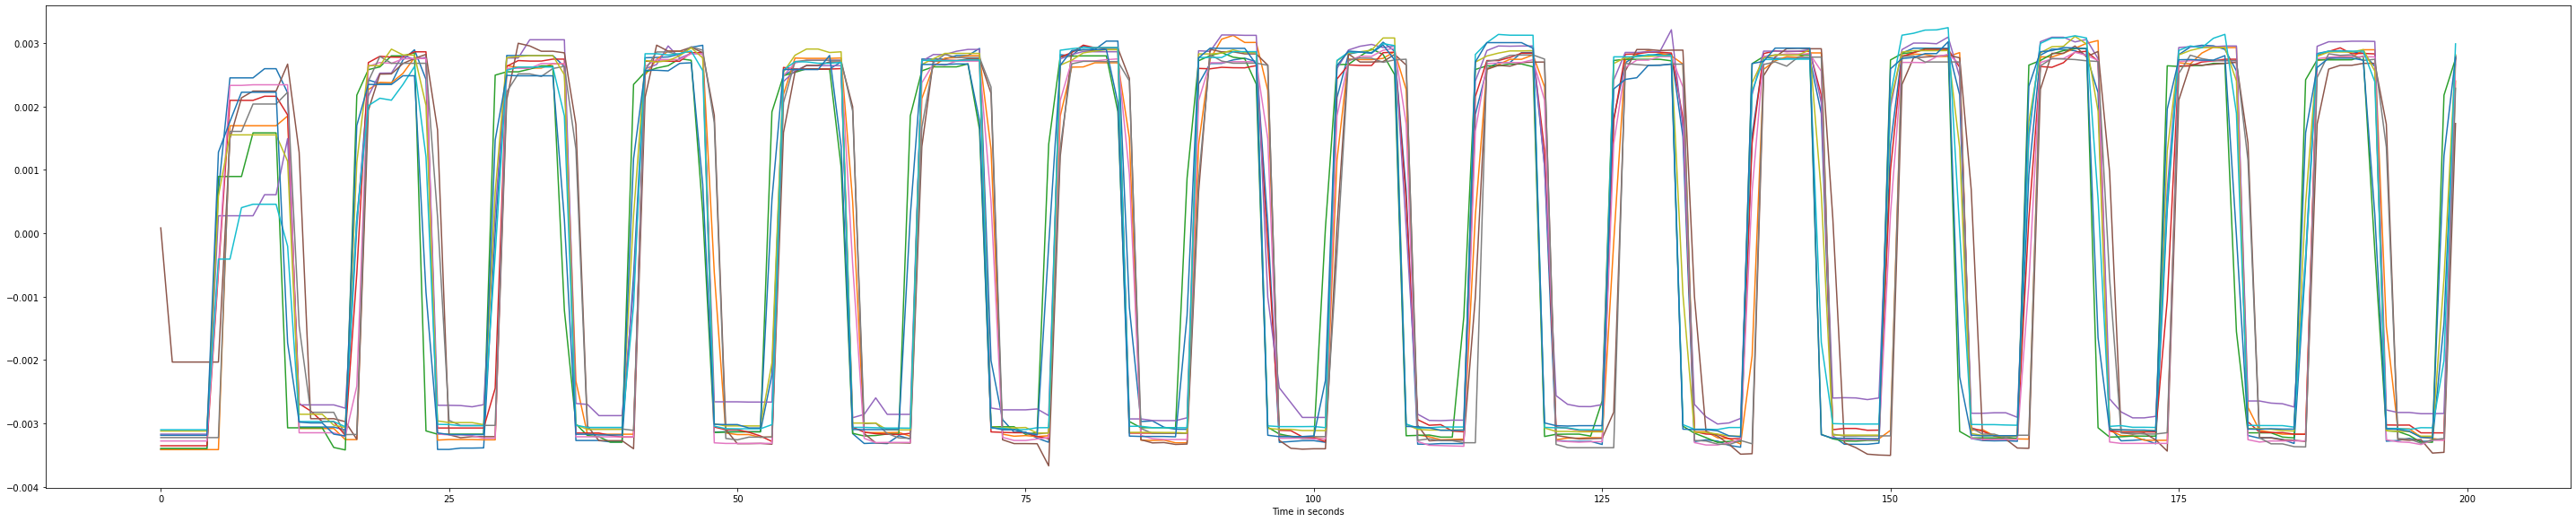

In [19]:
n_im = 12
import pandas
import functools as ft
var_holder = {}
# properties of our signals
fps = 30
eD = 0.5       # expected Duty cycle of 0.5
ef_red = 0.5   # expected frequency of 0.5 Hz
ef_blue = 2.5  # expected frequency of 2.5 Hz



colors = {0: 'red', 1: 'blue', None: 'gray'}
N = 200
N_ICA = -1  # numbers of samples to use for ICA, -1 for all

led_signals = np.zeros([rgb_frames.shape[0], 2], dtype=np.double)
fig, ax = plt.subplots(1, figsize=(40, 8), sharex="col", sharey=True )
first = 0
for eye in tnrange(12):

    rgb_frames = np.fromfile(videos[eye].with_suffix('.rgb'), dtype=np.uint8).reshape(-1, 16, 16, 3)

    # ICA to extract blinking signals from noise/variation
    num_components = 3
    ica = FastICA(n_components=num_components, random_state=0)
    demixed = ica.fit_transform(rgb_frames.reshape(rgb_frames.shape[0], -1).astype(float)[:N_ICA, :])
    mix_weights = ica.mixing_.mean(axis=0)
    
    dD = np.zeros(demixed.shape[1])
    df_red = np.zeros(demixed.shape[1])
    df_blue = np.zeros(demixed.shape[1])
    df_red_vs_time = pandas.DataFrame({'key' : [], 'r' : []})

    data = np.genfromtxt(time_stamps[eye], delimiter=',', names=True)
    time_meta = data['Timestamps_M']
    for n in range(demixed.shape[1]):

        # Check the mixing weights if the demixed signal polarity is reversed
        # (negative weights for ROI. Assuming rest of pixel array has weight zero, mean weight tells us sign.)
        flip_ica = mix_weights[n] < 0
        if flip_ica:
            demixed[:, n] = -demixed[:, n]

        km = KMeans(n_clusters=2, random_state=0).fit(demixed[:, n].reshape(-1, 1))
        y_km = km.predict(demixed[:, n].reshape(-1, 1))

        # check polarity, if necessary flip to match pulse polarity
        centers = km.cluster_centers_.ravel()

        flip_kmeans = centers[0] > centers[1]
        flip = flip_ica ^ flip_kmeans

        if flip_kmeans:
            y_km = np.abs(y_km-1)

        duty_cycle = y_km.sum()/len(y_km)
        freq = (np.diff(y_km)>0).sum()/len(y_km) * fps
        dD[n] = abs(eD-duty_cycle)
        df_red[n] = abs(ef_red - freq)
        df_blue[n] = abs(ef_blue - freq)
        
        # Attempt to identify the ICA signal as a color LED
        good_DC = dD[n] < 0.2 * eD
        good_freq = np.array([df_red[n] < ef_red * 0.1, df_blue[n] < ef_blue * 0.1])
        is_signal = good_DC and good_freq.sum()
        signal_color = good_freq.argmax() if is_signal else None
        
        sig_col = colors[signal_color]
        sig_name = 'None' if signal_color is None else colors[signal_color]

        if sig_col=='blue':
            a = y_km[:N]
            df_temp = pandas.DataFrame({'key' : [], "Red_LED_Intensity_%s" %(eye) : []})
            df_temp['key'] = time_meta[0:len(demixed[:N, n])]
            df_temp["Red_LED_Intensity_%s" %(eye)] = demixed[:N, n]
            ax.plot(demixed[:N, n])
            print(eye)
            if eye==0:
                df0 = df_temp
            elif eye==1:
                df1 = df_temp
            elif eye==2:
                df2 = df_temp
            elif eye==3:
                df3 = df_temp
            elif eye==4:
                df4 = df_temp
            elif eye==5:
                df5 = df_temp
            elif eye==6:
                df6 = df_temp
            elif eye==7:
                df7 = df_temp
            elif eye==8:
                df8 = df_temp
            elif eye==9:
                df9 = df_temp
            elif eye==10:
                df10 = df_temp
            elif eye==11:
                df11 = df_temp
                

plt.tight_layout()
ax.set_xlabel('Time in seconds')
plt.savefig('ICA_for_each_eye_red_LED_intensity.png');



(12000, 13)


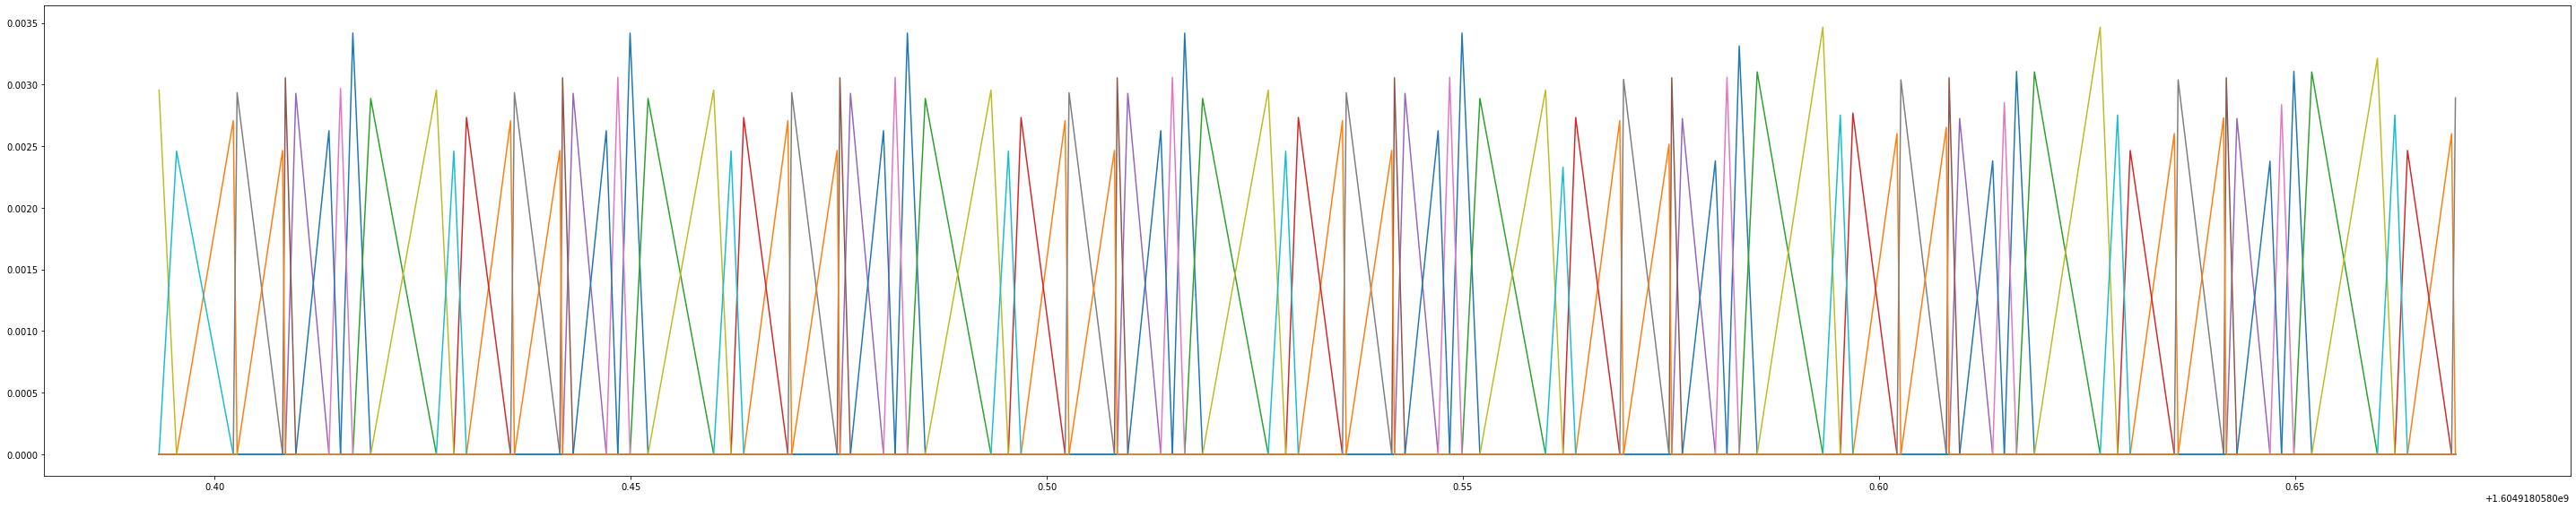

In [17]:
fig, ax = plt.subplots(1, figsize=(40, 8)) #sharex="col", sharey=True )

dfs = [df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]        
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='key', how='outer', suffixes=(None, None)), dfs)  
df_final = df_final.sort_values('key')
df_final = df_final.fillna(0)
width = 150000
# print(df_final.head(n=100))
print(df_final.shape)
# df_total = 0
for eye in range(12):
    ax.plot(df_final['key'][:100], df_final["Red_LED_Intensity_%s" %(eye)][:100])
    # df_total = df_total + df_final["Red_LED_Intensity_%s" %(eye)]


# ax.set_xlim([df_final['key'][0], df_final['key'][width]])
plt.tight_layout()  

(2400, 13)


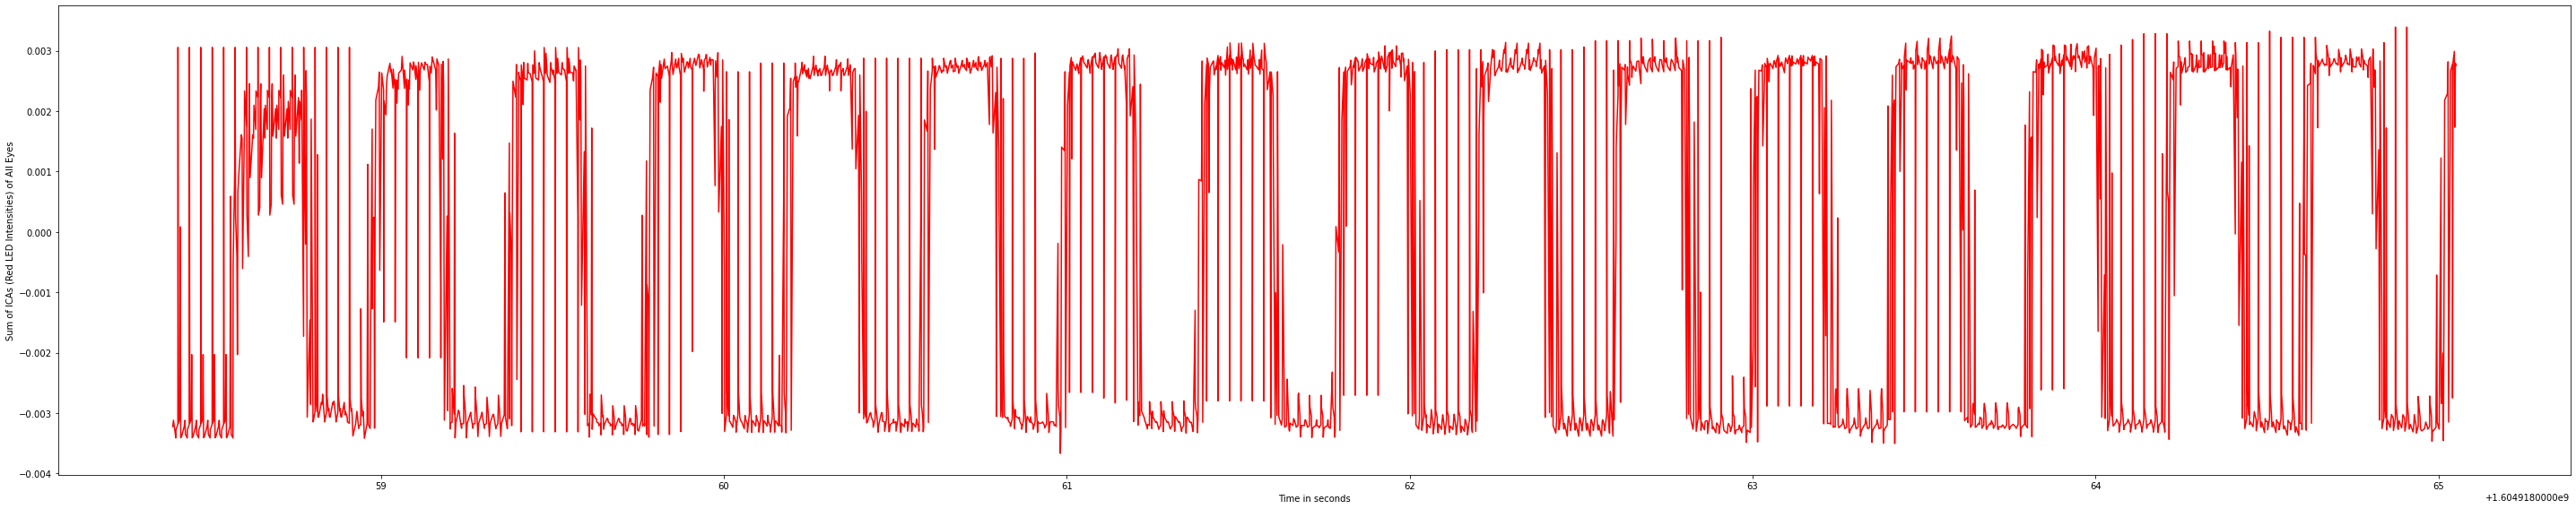

In [20]:
fig, ax = plt.subplots(1, figsize=(40, 8)) #sharex="col", sharey=True )
dfs = [df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]        
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='key', how='outer', suffixes=(None, None)), dfs)  
df_final = df_final.sort_values('key')
df_final = df_final.fillna(0)
width = -1
# print(df_final.head(n=100))
print(df_final.shape)
df_total = 0
for eye in range(12):
    # ax.plot(df_final['key'][:100], df_final["Red_LED_Intensity_%s" %(eye)][:100])
    df_total = df_total + df_final["Red_LED_Intensity_%s" %(eye)]
    
ax.plot(df_final['key'][-2500:-1], df_total[-2500:-1], c='r')
ax.set_xlabel('Time in seconds')
ax.set_ylabel('Sum of ICAs (Red LED Intensities) of All Eyes')

# ax.set_xlim([df_final['key'][0], df_final['key'][width]])
plt.tight_layout()
#plt.savefig('sum_of_ICAs_red_LED_intensity.png');

In [ ]:
?pd.DataFrame.interpolate

In [54]:
df0

key  Red_LED_Intensity_0
0      1.604918e+09             0.003418
1      1.604918e+09             0.003418
2      1.604918e+09             0.003418
3      1.604918e+09             0.003418
4      1.604918e+09             0.003418
...             ...                  ...
29995  1.604919e+09             0.002655
29996  1.604919e+09             0.003062
29997  1.604919e+09             0.003064
29998  1.604919e+09             0.003032
29999  1.604919e+09             0.003034

[30000 rows x 2 columns]

In [56]:
df_final.head()

key  Red_LED_Intensity_0  Red_LED_Intensity_1  \
239788  1.604918e+09                  NaN                  NaN   
269717  1.604918e+09                  NaN                  NaN   
30000   1.604918e+09                  NaN             0.002708   
209891  1.604918e+09                  NaN             0.002708   
329550  1.604918e+09                  NaN             0.002708   

        Red_LED_Intensity_2  Red_LED_Intensity_3  Red_LED_Intensity_4  \
239788                  NaN                  NaN                  NaN   
269717                  NaN                  NaN                  NaN   
30000                   NaN                  NaN                  NaN   
209891                  NaN                  NaN                  NaN   
329550                  NaN                  NaN                  NaN   

        Red_LED_Intensity_5  Red_LED_Intensity_6  Red_LED_Intensity_7  \
239788                  NaN                  NaN                  NaN   
269717                  NaN                  NaN                  NaN   
30000                   NaN                  NaN                  NaN   
209891                  NaN                  NaN             0.002934   
329550                  NaN                  NaN             0.002934   

        Red_LED_Intensity_8  Red_LED_Intensity_9  Red_LED_Intensity_10  \
239788             0.002955                  NaN                   NaN   
269717             0.002955              0.00246                   NaN   
30000              0.002955              0.00246                   NaN   
209891             0.002955              0.00246                   NaN   
329550             0.002955              0.00246                   NaN   

        Red_LED_Intensity_11  
239788                   NaN  
269717                   NaN  
30000                    NaN  
209891                   NaN  
329550              0.002466

In [59]:
df_total.shape

(359485,)

(2400, 13)


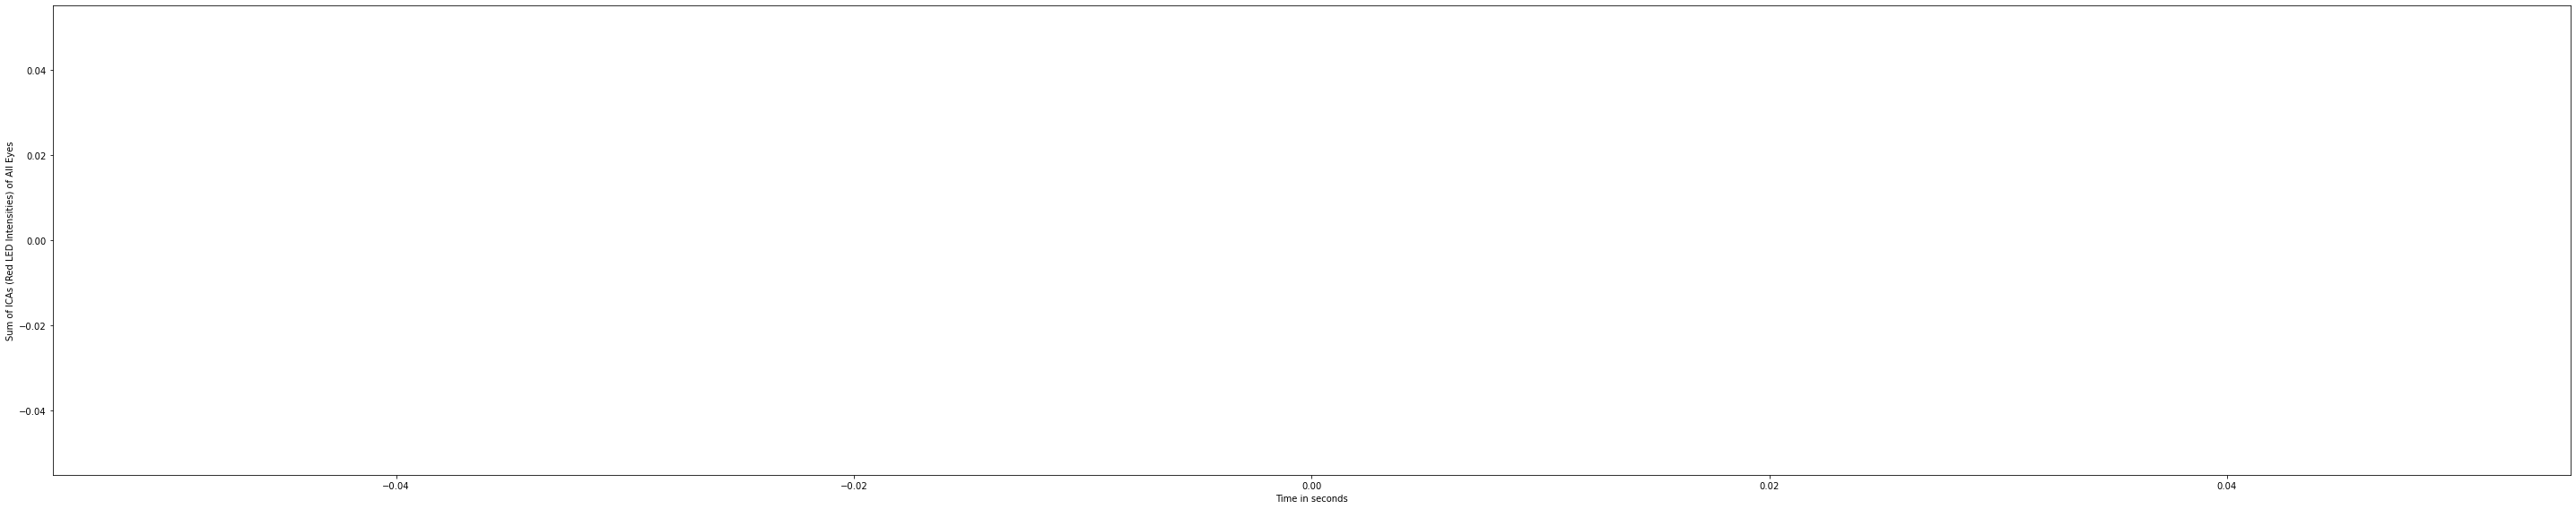

In [21]:
fig, ax = plt.subplots(1, figsize=(40, 8)) #sharex="col", sharey=True )
dfs = [df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]        
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='key', how='outer', suffixes=(None, None)), dfs)  
df_final = df_final.sort_values('key')
# df_final = df_final.fillna(0)
df_final.interpolate(inplace=True
                    )
width = 7000

# print(df_final.head(n=100))
print(df_final.shape)
df_total = 0
for eye in range(12):
    # ax.plot(df_final['key'][:100], df_final["Red_LED_Intensity_%s" %(eye)][:100])
    df_total = df_total + df_final[f"Red_LED_Intensity_{eye}"]
    
# df_final['key'][:2500], df_total[:2500], c='r'
ax.plot(df_total.values[230000:240000] > 0, c='r')
ax.set_xlabel('Time in seconds')
ax.set_ylabel('Sum of ICAs (Red LED Intensities) of All Eyes')

# ax.set_xlim([df_final['key'][0], df_final['key'][width]])
plt.tight_layout()
plt.savefig('sum_of_ICAs_red_LED_intensity.png');

(359485, 13)


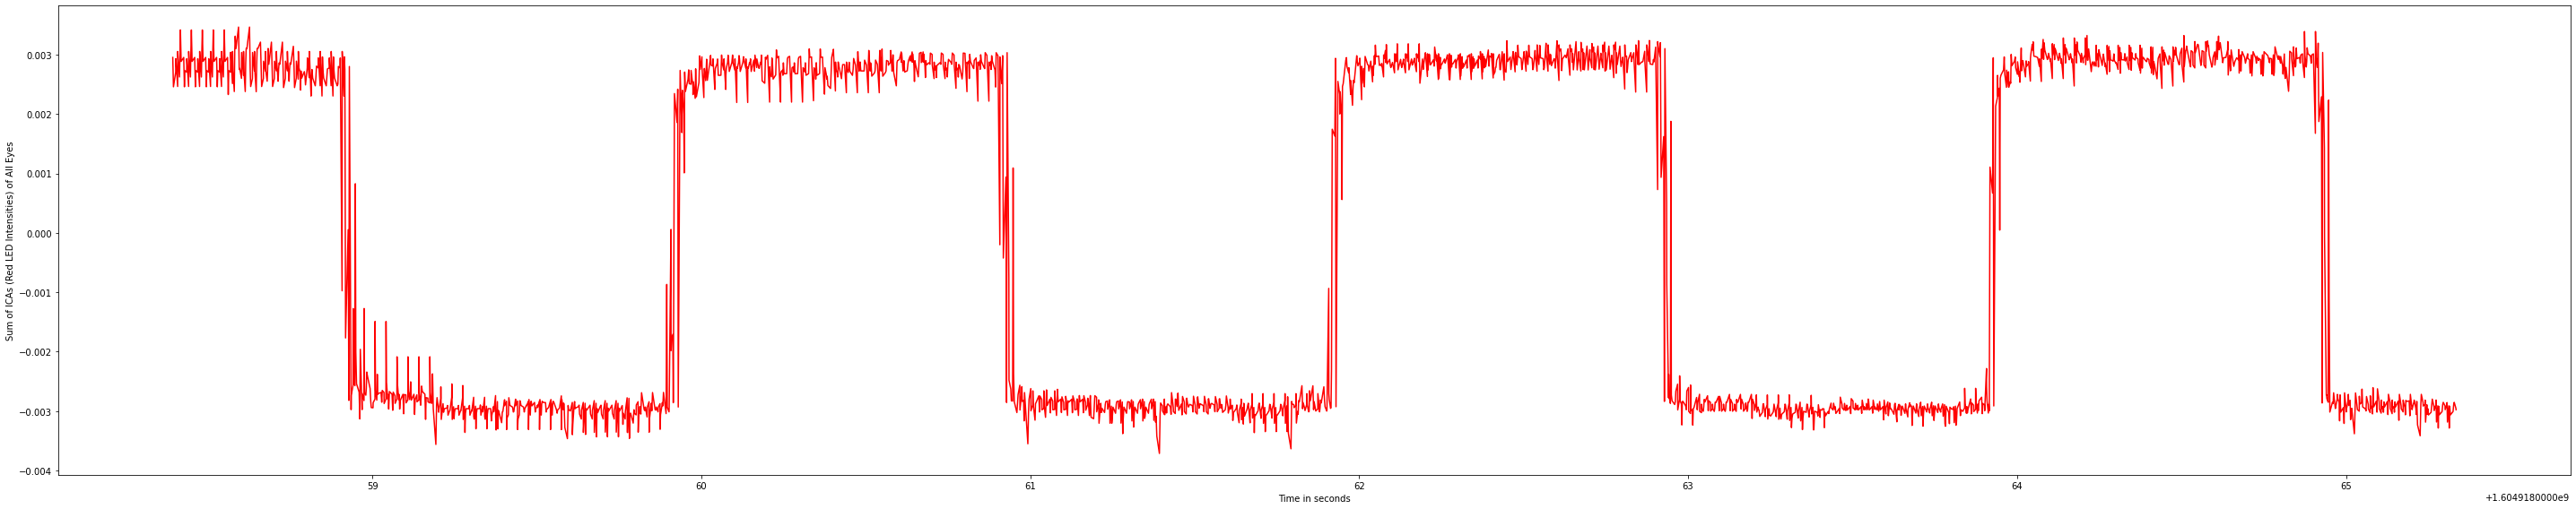

In [38]:
fig, ax = plt.subplots(1, figsize=(40, 8)) #sharex="col", sharey=True )
dfs = [df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]        
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='key', how='outer', suffixes=(None, None)), dfs)  
df_final = df_final.sort_values('key')
df_final = df_final.fillna(0)
width = -1
# print(df_final.head(n=100))
print(df_final.shape)
df_total = 0
for eye in range(12):
    # ax.plot(df_final['key'][:100], df_final["Red_LED_Intensity_%s" %(eye)][:100])
    df_total = df_total + df_final["Red_LED_Intensity_%s" %(eye)]
    
ax.plot(df_final['key'][:2500], df_total[:2500], c='r')
ax.set_xlabel('Time in seconds')
ax.set_ylabel('Sum of ICAs (Red LED Intensities) of All Eyes')

# ax.set_xlim([df_final['key'][0], df_final['key'][width]])
plt.tight_layout()
plt.savefig('sum_of_ICAs_red_LED_intensity.png');

In [ ]:
fig, ax = plt.subplots(2, figsize=(28, 7))
for n, c in enumerate(['r', 'b']):
    ax[n].plot(led_signals[:1000, n], c=c)

In [ ]:
comp = ica.mixing_.reshape(16, 16, 3, 3)
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for n in range(9):
    ax[n//3, n%3].imshow(comp[:,:,n//3,n%3])
    ax[n//3, n%3].set_xlabel(f'component {n%3}, color {n//3} ({n})')
plt.tight_layout()

In [ ]:
comp = ica.mixing_.reshape(16, 16, 3, 3)
plt.imshow(comp[:,:,0,:])

In [ ]:
compmax = comp / comp.max(axis=0).max(axis=0).max(axis=0)
plt.imshow(compmax[:,:,:,2])